In [1]:
import torch 
import torchvision 
import numpy as np

import os
import pandas as pd
import albumentations as A
import albumentations.pytorch
import cv2

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
# import torch.nn.functional as F

import sys
sys.path.append('../')
from dataset import val_transforms, CDataset

In [2]:
import easydict 
args = easydict.EasyDict({ "batch_size": 256, 
                          "epochs": 30, 
                          "data": 0, 
                          'lr':0.1,
                         'momentum':0.9,
                         'weight_decay':1e-4,
                         'start_epoch':0,
                         'gpu':0,
                          'workers':16,
                         'print_freq':2000,
                         'saved_dir':'../trained_models/checkpoint.pt'})

In [3]:
# make saved dir
from pathlib import Path
path = Path(args.saved_dir.split('checkpoint')[0])
path.mkdir(parents=True, exist_ok=True)

In [4]:
ngpus_per_node = torch.cuda.device_count()
print(ngpus_per_node)
GPU_NUM = args.gpu # 원하는 GPU 번호 입력
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)
print(device)

3
cuda:0


In [5]:
from augment import *

In [6]:
IMAGE_SIZE = 256
train_transforms = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE, p=1),
    A.OneOf([
        A.HorizontalFlip(p=.8),
        A.VerticalFlip(p=.8),
        A.RandomRotate90(p=.8)]
    ),
    # HEColorAugment(sigma1=.4, sigma2=5., mat=None, p=0.9),
], p=1.0) 

In [7]:
import albumentations as A
import albumentations.pytorch
import cv2

class CDataset(Dataset):
    def __init__(self, df, defaultpath='/home/beomgon/Dataset/new_patches/', transform=None):
        self.df = df
        self.transform = transform
        self.dir = defaultpath

    def __len__(self):
        return len(self.df)   

    def __getitem__(self, idx):
        path = self.df.iloc[idx, 4]
#         print(pid)

        image = cv2.imread(self.dir + path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         image = (image.astype(np.float32)-128.)/128.
        
#         if image is uint8, normalization by 255 is done automatically by albumebtation(ToTensor method)
        if self.transform:
            timage = self.transform(image=image)
            image = timage['image']
        
        image =  torch.tensor(image, dtype=torch.float32)/255.
        #image = (torch.tensor(image, dtype=torch.float32)-128)/128
        image = image.permute(2,0,1)
            
        label = self.df.iloc[idx, 5]
        return image, label, path

In [8]:
train_df = pd.read_csv('../dataframe/train_New_Stomach_df.csv')
train_dataset = CDataset(train_df, defaultpath='/home/beomgon/Dataset/seegene/new_patches/', 
                         transform=train_transforms)

val_df = pd.read_csv('../dataframe/val_New_Stomach_df.csv')
val_dataset = CDataset(val_df, defaultpath='/home/beomgon/Dataset/seegene/new_patches/',
                       transform=val_transforms)  

test_df = pd.read_csv('../dataframe/test_New_Stomach_df.csv')
test_dataset = CDataset(test_df, defaultpath='/home/beomgon/Dataset/seegene/new_patches/',
                        transform=val_transforms)  

In [9]:
image, label, path = next(iter(train_dataset))
# image

In [10]:
train_loader = DataLoader(train_dataset, batch_size=args.batch_size,
                          shuffle=True, num_workers=args.workers)

val_loader = DataLoader(val_dataset, batch_size=args.batch_size,
                          shuffle=True, num_workers=args.workers)

test_loader = DataLoader(test_dataset, batch_size=args.batch_size,
                          shuffle=True, num_workers=args.workers)


In [11]:
# images, labels, paths = next(iter(train_loader))
# images.shape

In [12]:
from resnet import BasicBlock, conv1x1, conv3x3, Bottleneck
from typing import Type, Any, Callable, Union, List, Optional

import torch
import torch.nn as nn
from torch import Tensor

from torch.hub import load_state_dict_from_url
class ResNet(nn.Module):
    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        layers: List[int],
        num_classes: int = 1000,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
#         _log_api_usage_once(self)
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 16
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(
                "replace_stride_with_dilation should be None "
                f"or a 3-element tuple, got {replace_stride_with_dilation}"
            )
        self.groups = groups
        self.base_width = width_per_group
        self.LT = nn.Parameter(torch.eye(3, dtype=torch.float), requires_grad=True)
        self.LT_ma = torch.eye(3, dtype=torch.float, device='cuda')
#         self.bn0 = norm_layer(3)
#         self.scale = nn.Parameter(torch.tensor([1., 1., 1,]), requires_grad=True)
#         self.bias = nn.Parameter(torch.tensor([0., 0., 0,]), requires_grad=True)
        
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 32, layers[0])
        self.layer2 = self._make_layer(block, 64, layers[1], stride=2, dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 32, layers[2], stride=2, dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 16, layers[3], stride=2, dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(16 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        planes: int,
        blocks: int,
        stride: int = 1,
        dilate: bool = False,
    ) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, self.groups, self.base_width, previous_dilation, norm_layer
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)
    
    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)


def _resnet(
    arch: str,
    block: Type[Union[BasicBlock, Bottleneck]],
    layers: List[int],
    pretrained: bool,
    progress: bool,
    **kwargs: Any,
) -> ResNet:
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch], progress=progress)
        model.load_state_dict(state_dict)
    return model


def resnet18(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet("resnet18", BasicBlock, [2, 2, 2, 2], pretrained, progress, **kwargs)

In [13]:
# import torchvision.models as models
# from resnet import resnet18
model = resnet18(pretrained=False)
model.fc = nn.Linear(16, 3)
torch.nn.init.normal_(model.fc.weight, std=0.01)
torch.nn.init.constant_(model.fc.bias, 0.)
default_state_dict = model.state_dict()
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
# optimizer = torch.optim.Adam(params, lr=0.01, weight_decay=args.weight_decay)
optimizer = torch.optim.SGD(
       params, lr=args.lr, momentum=args.momentum, weight_decay=args.weight_decay)
# optimizer = torch.optim.SGD(params, lr=args.lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15, 20, 25, 30], 
                                                    gamma=0.2)
# criterion = nn.CrossEntropyLoss(label_smoothing=0.0)
criterion = nn.CrossEntropyLoss().to(device)

In [14]:
from main import *

In [15]:
ratio = [.8, .8, .8]
acc_list = []
test_acc = []

for num in range(len(ratio)) :
    args.saved_dir = '../trained_models/resnet8/stomach5_3' + str(num) + '/checkpoint.pt'
    path = Path(args.saved_dir.split('checkpoint')[0])
    path.mkdir(parents=True, exist_ok=True)  
    
    model = resnet18(pretrained=False)
    # model.fc.out_features = 3
    model.fc = nn.Linear(16, 3)
    torch.nn.init.normal_(model.fc.weight, std=0.01)
    torch.nn.init.constant_(model.fc.bias, 0.)    
    # model.load_state_dict(default_state_dict)
    model.to(device)

    params = [p for p in model.parameters() if p.requires_grad]
#     optimizer = torch.optim.Adam(params, lr=0.01, weight_decay=args.weight_decay)
    optimizer = torch.optim.SGD(
           params, lr=args.lr, momentum=args.momentum, weight_decay=args.weight_decay)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15, 20, 25], 
                                                        gamma=0.2)
    # criterion = nn.CrossEntropyLoss(label_smoothing=0.0)
    criterion = nn.CrossEntropyLoss().to(device)
    
    best_acc1 = 0
    acc1 = 0
    train_loss = []
    val_acc = []

    for epoch in range(args.epochs):
#         print('lr', optimizer.param_groups[0]['lr'])
        losses = train(train_loader, model, criterion, optimizer, epoch, args)
        scheduler.step()

        # evaluate after every epoch
        acc1 = validate(val_loader, model, criterion, args)   
        val_acc.append(acc1.item())

        # remember best acc@1 and save checkpoint
        is_best = acc1 > best_acc1
        best_acc1 = max(acc1, best_acc1) 

        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'best_acc1': best_acc1,
            'optimizer' : optimizer.state_dict(),
            'scheduler' : scheduler.state_dict(),
        }, is_best, filename=args.saved_dir)   
        
    checkpoint = torch.load(args.saved_dir)
    model.load_state_dict(checkpoint['state_dict'])
    acc1 = validate(test_loader, model, criterion, args)    
    print('************* test number {} ratio {} acc{} *************'.format(num, ratio[num], acc1))    
    acc_list.append(val_acc)    
    test_acc.append(acc1)
    

Epoch: [0][  0/297]	Time  2.513 ( 2.513)	Data  1.954 ( 1.954)	Loss 1.1015e+00 (1.1015e+00)	Acc@1  34.77 ( 34.77)
Test: [  0/102]	Time  1.621 ( 1.621)	Loss 5.7205e+00 (5.7205e+00)	Acc@1  39.06 ( 39.06)
 * Acc@1 35.665
Epoch: [1][  0/297]	Time  1.790 ( 1.790)	Data  1.674 ( 1.674)	Loss 7.3471e-01 (7.3471e-01)	Acc@1  73.83 ( 73.83)
Test: [  0/102]	Time  1.884 ( 1.884)	Loss 1.1093e+00 (1.1093e+00)	Acc@1  66.02 ( 66.02)
 * Acc@1 64.481
Epoch: [2][  0/297]	Time  1.806 ( 1.806)	Data  1.704 ( 1.704)	Loss 6.9215e-01 (6.9215e-01)	Acc@1  71.48 ( 71.48)
Test: [  0/102]	Time  1.909 ( 1.909)	Loss 3.6385e+00 (3.6385e+00)	Acc@1  37.89 ( 37.89)
 * Acc@1 35.126
Epoch: [3][  0/297]	Time  2.107 ( 2.107)	Data  1.996 ( 1.996)	Loss 5.9909e-01 (5.9909e-01)	Acc@1  77.73 ( 77.73)
Test: [  0/102]	Time  1.871 ( 1.871)	Loss 2.6931e+00 (2.6931e+00)	Acc@1  46.48 ( 46.48)
 * Acc@1 48.222
Epoch: [4][  0/297]	Time  1.762 ( 1.762)	Data  1.650 ( 1.650)	Loss 4.1445e-01 (4.1445e-01)	Acc@1  84.77 ( 84.77)
Test: [  0/102]	Tim

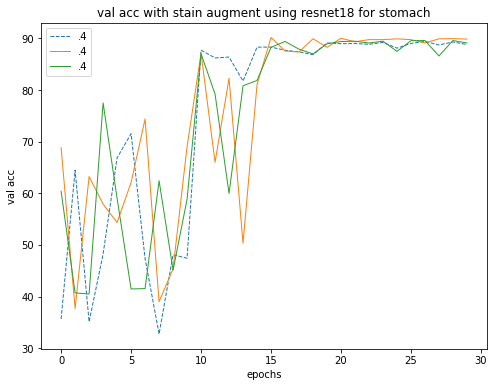

[tensor(91.0245, device='cuda:0'), tensor(91.4875, device='cuda:0'), tensor(90.9981, device='cuda:0')]


In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

epochs = range(args.epochs)
plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams['lines.linewidth'] = 1
plt.plot(epochs, acc_list[0], linestyle='--')
plt.plot(epochs, acc_list[1])
plt.plot(epochs, acc_list[2])
# plt.plot(epochs, acc_list[3])
plt.legend(['.4', '.4', '.4' ])
plt.xlabel('epochs')
plt.ylabel('val acc')
plt.title('val acc with stain augment using resnet18 for stomach')
# plt.axis([10, 30, 88, 94])
plt.show()
print(test_acc)